In [16]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
torch.manual_seed(2)

<h2 id="Model">Neural Network Module and Training Function</h2> 


<img src="https://ibm.box.com/shared/static/5wtclahun0f70qlwkn2kxzh3amnbq4zg.png" width="200" alt="Neural Network Model">


In [17]:
# Using relu activation function
class NetRelu(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        '''
        D_in = Total dimenstiom in the input layer
        H1 = Total neurons in the first hidden layer
        H2 = Total neurons in the second hidden layer
        D_out = Total output from from model
        '''
        super(NetRelu, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1,H2)
        self.linear3 = nn.Linear(H2, D_out)
        
    # Predictions
    def forward(self, x):
        x = torch.relu(self.linear1(x)) # Hidden layer 1
        x = torch.relu(self.linear2(x)) # Hidden layer 2
        x = self.linear3(x) # Output layer
        return x

In [18]:
# Train the model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss': [], 'validation_accuracy': []}  
    
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
        
        correct = 0
        for x, y in validation_loader:
            z = model(x.view(-1, 28 * 28))
            _, label = torch.max(z, 1)
            correct += (label == y).sum().item()
    
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff, model

In [19]:
# Make some data
train_dataset = dsets.MNIST(root = './data', train = True, download = True, transform = transforms.ToTensor())

# Create the validating dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


# Create the training data loader and validation data loader object
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

In [20]:
# Define the model parameters
criterion = nn.CrossEntropyLoss()

# Set the parameters for create the model
input_dim = 28*28
hidden_dim1 = 50
hidden_dim2 = 50
output_dim = 10

# Set the epoch numbers
cust_epochs = 50

learning_rate = 0.01

In [21]:
# Train the model

modelRelu = NetRelu(input_dim, hidden_dim1, hidden_dim2, output_dim)
optimizer = torch.optim.SGD(modelRelu.parameters(), lr = learning_rate)
training_results_relu, model = train(modelRelu, criterion, train_loader, validation_loader, optimizer, epochs = cust_epochs)

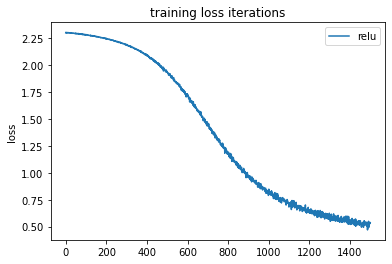

In [22]:
# Compare the training loss
plt.plot(training_results_relu['training_loss'], label='relu')
plt.ylabel('loss')
plt.title('training loss iterations')
plt.legend()

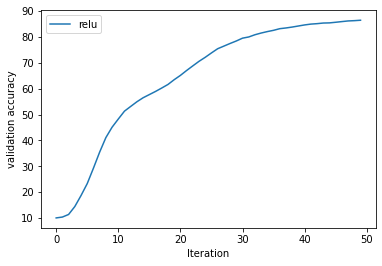

In [23]:
plt.plot(training_results_relu['validation_accuracy'], label = 'relu') 
plt.ylabel('validation accuracy')
plt.xlabel('Iteration')   
plt.legend()

<h1>Deeper Neural Networks with nn.ModuleList()</h1>

Lets say we want to try even more deeper NN, we can do this dynamically using nn.ModuleList() functionality.

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1)

In [37]:
# Define the function to plot the diagram

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _, yhat = torch.max(model(XX), 1)
    yhat = yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:] == 0, 0], X[y[:] == 0, 1], 'ro', label = 'y=0')
    plt.plot(X[y[:] == 1, 0], X[y[:] == 1, 1], 'go', label = 'y=1')
    plt.plot(X[y[:] == 2, 0], X[y[:] == 2, 1], 'o', label = 'y=2')
    plt.title("decision region")
    plt.legend()

In [40]:
# Create Data Class

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r*np.cos(t)]
          y[ix] = j
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
    
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_stuff(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y = 0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y = 1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(), self.x[self.y[:] == 2, 1].numpy(), 'go', label="y = 2")
        plt.legend()

<h2 id="Model">Neural Network Module and Function for Training</h2>

Neural Network Module using <code>ModuleList()</code>

In [64]:
class Net(nn.Module):
    
    # Constructor:
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size)) # builds linear models on different hidden layers
            
    # Prediction 
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l<L-1:
                activation = F.relu(linear_transform(activation)) # relu in hidden layers
            else:
                activation = linear_transform(activation) # Linear function in last layer
        return activation
    
    
# Define the function for training the model
def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            LOSS.append(loss.item())
        ACC.append(accuracy(model, data_set))
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS, color = color)
    ax1.set_xlabel('Iteration', color = color)
    ax1.set_ylabel('total loss', color = color)
    ax1.tick_params(axis = 'y', color = color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color = color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color = color)
    ax2.tick_params(axis = 'y', color = color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return LOSS

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x),1)
    return (yhat==data_set.y).numpy().mean()

<h2 id="Train">Train and Validate the Model</h2>

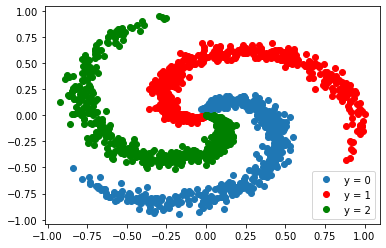

In [67]:
# Create the dataset object

data_set = Data()
data_set.plot_stuff()
data_set.y = data_set.y.view(-1)

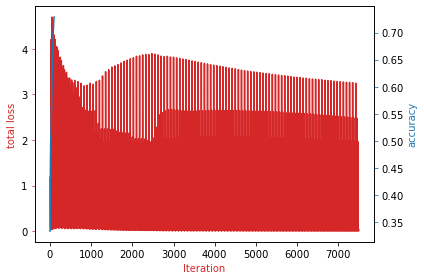

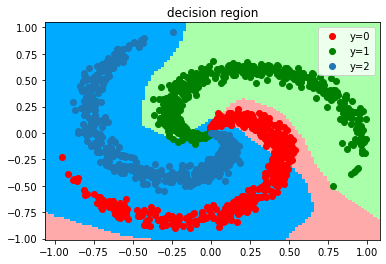

In [44]:
# Training the model with 1 hidden layer with 50 neurons

Layers = [2,50,3]
model = Net(Layers)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 100)

plot_decision_regions_3class(model, data_set)

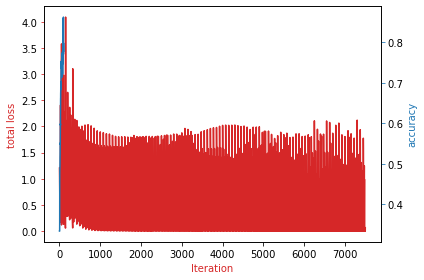

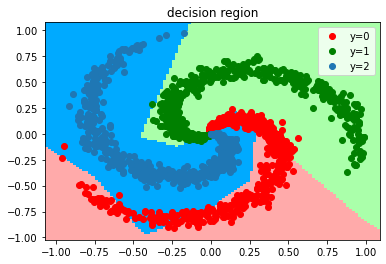

In [48]:
# Create a network with 2 hidden layers with 20 neurons in total

# Training the model with 1 hidden layer with 50 neurons

Layers = [2,10,10, 3]
model = Net(Layers)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 100)

plot_decision_regions_3class(model, data_set)

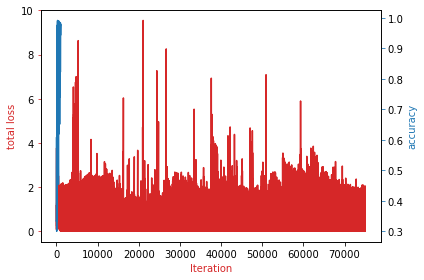

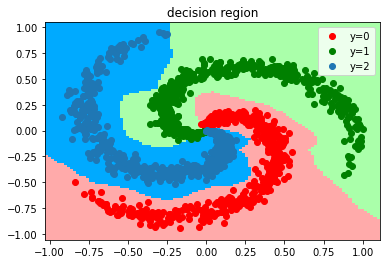

In [68]:
# Create a network with 3 hidden layers with 20 neurons in total

# Training the model with 1 hidden layer with 50 neurons

Layers = [2,20,20,20,3]
model = Net(Layers)
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()
LOSS = train(data_set, model, criterion, train_loader, optimizer, epochs = 1000)

plot_decision_regions_3class(model, data_set)